# Programming Assignment 02 [50 marks]


This assignment will introduce you to implement and train a `Vision Transformer (ViT)` which was covered in the class. Here, we will code all the building blocks and integrate all of them to build the complete model. We will mostly follow the skeletal notebook from the PA-01.


This code has been tested and should run for Python 3.7.10 with pytorch 1.7.0 and pytorch_lightning 1.2.0 in Google colab. The advantage of colab is that you can use GPUs for small codes that does not need very long runtime.

Details: (double-click here to fill)

Name: `<write your name here>`

Roll Number: `<write your roll number here>`

Make sure to go through all the comments and texts in this notebook, as they contain specific instructions to complete the assignment. You would need to submit a single `.ipynb` file. Write your codes only between the START and END markers. All the required outputs must be embedded in the notebook itself. Feel free to reach out to the TAs through Piazza if you have any doubts. Happy coding (and learning)!

## Part 0: Tutorials

You will find these tutorials on pytorch and pytorch_lightning useful:
 - [Pytorch Tutorials](https://pytorch.org/tutorials/) - "Learn the Basics" is very good starter
 - [Pytorch-lightning masterclass](https://www.youtube.com/playlist?list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2) - around 140 minutes of videos
 - [deep-learning-project-template](https://github.com/PyTorchLightning/deep-learning-project-template/blob/master/project/lit_image_classifier.py) - You will find this project template from the official pytorch-lightning repo very useful. We have, mostly, tried to follow this template for this assignment.
 - If you want to read more about vision transformers, here's the link to the paper: https://arxiv.org/pdf/2010.11929v2.pdf

## Part 1: Building and training a Vision Transformer Model (ViT)

First, get the data to the working folder. We will only use the tiny-ImageNet dataset, whose drive link is as follows (the same link which was given for assignment-1):

Tiny ImageNet - https://drive.google.com/file/d/1VO2ooFlzw6VD2P5hx535V0Rlbo9C6ldc/view?usp=sharing


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy data from drive

In [ ]:
# copy the data and unzip it in the working folder
!scp /content/drive/MyDrive/Tiny_ImageNet_200.zip ./
!unzip Tiny_ImageNet_200.zip

Install the required dependencies

In [ ]:
# install pytorch lighting
! pip install pytorch-lightning --quiet
! pip install einops

Import required libraries

In [ ]:
# List of imports
from PIL import Image
from typing import Type, Any, Callable, Union, List, Optional

## PyTorch
import torch
from torch import Tensor
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## PyTorch lightning
import pytorch_lightning as pl
import torchmetrics
# Torchvision
import torchvision
from torchvision import transforms

# import TensorBoardLogger
from pytorch_lightning.loggers import TensorBoardLogger

from math import sqrt

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

The diagram shows the model overview of Vision Transformer. Given an image, we split into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used. 

Image courtesy: https://arxiv.org/pdf/2010.11929v2.pdf

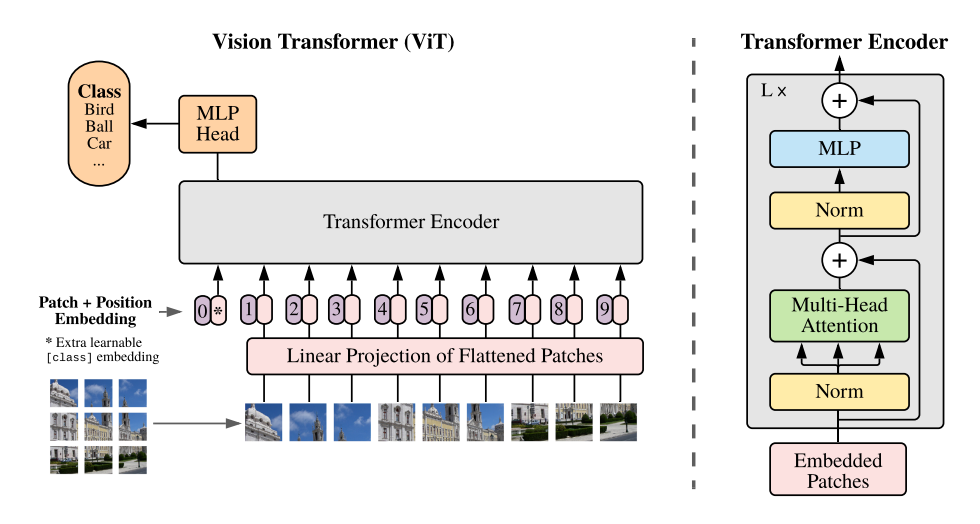

Code for various components of ViT

In [ ]:
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

`[8 marks]`

In [ ]:
# classes
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Declare a sequential network: 
        # linear [dim->hidden_dim], 
        # gelu activation,
        # dropout layer,
        # linear [hidden_dim, dim],
        # dropout layer
        ###################################
        ####   Code required (end)   ####
        ###################################
  
    def forward(self, x):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Simply pass the input x through the declared network (1 line code)
        ###################################
        ####   Code required (end)   ####
        ###################################

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        # Multi-head attention block
        # All the required layers are declared here:
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the forward function by using all the declared layers above
        # Keeping track of the shape of the intermediate outputs can be handy in writing the code correctly
        # einops has a very cool rearrange feature: https://einops.rocks/api/rearrange/ you can use it here
        # The forward function should attend over the input x, and return the output
        ###################################
        ####   Code required (end)   ####
        ###################################

`[3 marks]`

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the forward function
        # Pass the input x through all the layers and return the output
        ###################################
        ####   Code required (end)   ####
        ###################################

`[20 marks]`

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        ###################################
        ####   Code required (start)   ####
        ###################################
        # assert that image size is divisible by patch size (1 line of code)
        # compute number of patches (1 line of code)
        assert ##
        num_patches = ##
        ###################################
        ####   Code required (end)   ####
        ###################################
        
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # patch to embedding
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        ###################################
        ####   Code required (start)   ####
        ###################################
        # Declare positional embedding and cls token
        # pos_embedding shape: 1, num_patches + 1, dim
        # cls_token shape: 1, 1, dim
        # both should be randomly intialized, and should be nn.Parameter to make them learnable
        self.pos_embedding = 
        self.cls_token = 
        ###################################
        ####   Code required (end)   ####
        ###################################

        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        ###################################
        ####   Code required (start)   #### 
        ###################################
        # Declare the mlp head
        # Sequential of:
        # layernorm [dim]
        # linear [dim->num_classes]
        self.mlp_head = 
        ###################################
        ####   Code required (end)   ####
        ###################################

        

    def forward(self, img):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the forward function of the ViT
        # Use all the layers and components declared above
        # Keeping track of the input and output shapes of all the components is always handy for writing the forward function quickly

        ###################################
        ####   Code required (end)   ####
        ###################################

`[8 marks]`

In [ ]:
class My_ViT_Classifier(pl.LightningModule):
    def __init__(self, image_size=224, patch_size=16, num_classes=200, dim=192, depth=3, heads=12, mlp_dim=384, pool = 'cls', channels = 3, dim_head = 64, learning_rate=3e-3):
        '''
        image_size: dimension of image (224 x 224)
        patch_size: dimension of patches (16 x 16)        
        num_classes: Number of classes in the dataset (200 for tiny-Imagenet)
        dim: hidden dimension of the transformer
        depth: depth of the transformer
        heads: number of heads for multi-head attention
        mlp_dim: hidden dimension for mlp 
        dim_head: dimension of each head for attention        
        learning_rate: The learning rate hyperparameter

        Don't change any of these values
        '''
        super().__init__()
        # 'save_hyperparameters' saves the values of anything in the __init__ for us to the checkpoint.
        # This is a useful feature.
        self.save_hyperparameters()

        self.backbone = ViT(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, pool = pool, channels = channels, dim_head = dim_head)
        
        self.num_classes = num_classes
        self.accuracy = torchmetrics.Accuracy()
    
    def forward(self, x):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # use forward for inference/predictions

        ###################################
        ####    Code required (end)    ####
        ###################################
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        # Logging training loss on each training step and also on each epoch
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####   Code required (start)   ####
        ###################################
        # get the predictions, find accuracy, and log it.

        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def validation_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the validation step here.
        # Make sure to log the val_loss and val_acc as you did in the training step

        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def test_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the test step here.
        # Make sure to log the test_loss and test_acc.
        # Code is very similar to that of the validation step.

        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Now, we will train ViT!

In [ ]:
# Setting the seed for reproducibility
pl.seed_everything(101)

# ------------
# args
# ------------
# Path to the folder where the Tiny ImageNet dataset is/will be downloaded

DATASET_PATH = "/content/Tiny-ImageNet-200/"
# Choice of activation functions as dict

# ------------
# data
# ------------

# As we have learned in the class, it is important to have the data preprocessed with a zero mean. 
# The following values are the mean and std for tiny-imagenet:
DATA_MEANS = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]
print("Mean of data:", DATA_MEANS)
print("Standard deviation of data:", DATA_STD)

# We will use the mean and standard deviation of the input data computed above to normalize the input.

# Note that the above normalization will be applied to both test/valiadtion and traning data. The training data,
# in addition, will need to go through a few more data augmentations. We plan to use following data augmentations.
# 1. Random horizontal flip with 50% probability - RandomHorizontalFlip
# 2. Crop the image to random size and aspect ratio. This crop is finally resized to given size - RandomResizedCrop
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Next we will split the training data into training and validation. You will notice that we use the same command
# in the next two lines. This is a trick, often used to make sure that training data uses the random data augmentations
# while validation data do not.

tiny_imagenet_dataset_train = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
tiny_imagenet_dataset_val_test = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)
# declared the same thing multiple times because of different transforms. just a hack (inefficient though)
num_imgs = len(tiny_imagenet_dataset_train)
print("Total number of images:", num_imgs)

# Let's split the dataset as: train: 65%, val: 10%, test: 25%.
train_length = int(0.65*num_imgs)
val_length = int(0.1*num_imgs)
test_length = num_imgs - train_length - val_length

print(train_length, val_length, test_length)

train_set, _, _ = data.random_split(tiny_imagenet_dataset_train, [train_length, val_length, test_length])
_, val_set, test_set = data.random_split(tiny_imagenet_dataset_val_test, [train_length, val_length, test_length])

# Define a set of data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# ------------
# model
# ------------
# We will use a ResNet-50 model for this assignment. 
# You may try experimenting with ResNet-101 and ResNet-152 to find out
# But, training these larger networks will demand more computation and memory requirements.
# the effect of depth in the performance of a neural network.
model = My_ViT_Classifier(num_classes=200, learning_rate=3e-3)
# ------------
# logging
# ------------
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'tiny-imagenet', 'ViT')

# ------------
# training
# ------------
# Initialize a trainer
trainer = pl.Trainer(max_epochs=40,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)
# expect a per epoch time taken to be around 3.5 minutes (on Colab using GPU backend)

`[2 marks]`

In [ ]:
###################################
####   Code required (start)   ####
###################################
# Write the code to save the checkpoint
# and show the evaluation
# results on validation and test set

###################################
####    Code required (end)    ####
###################################

#Implementing Shifted Patch Token (SPT) for small datasets.

It is well known that ViTs are data hungry and underperform on small datasets like tiny-Imagenet. The paper https://arxiv.org/pdf/2112.13492.pdf proposed some specific modifications in this regard to improve performance of ViTs on small datasets. We would now implement one of the proposed components called "Shifted Patch Tokenization (SPT)" which is very simple and is discussed in the class.

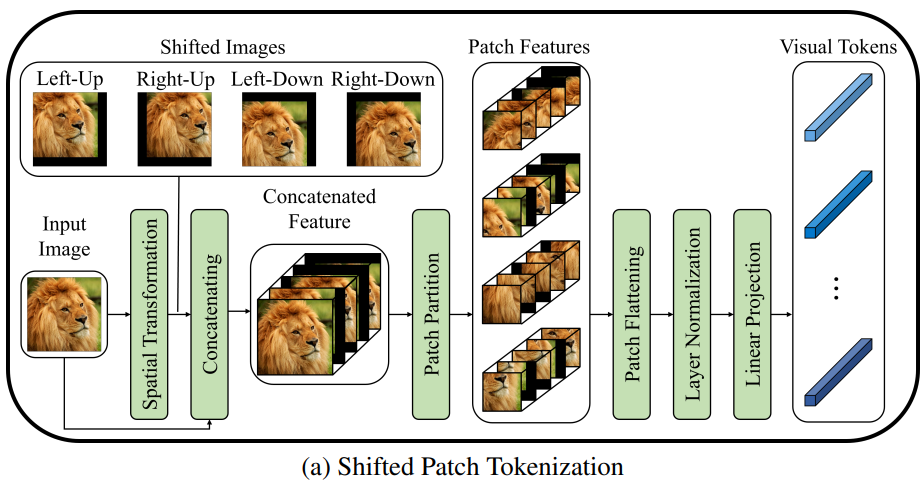

Image courtesy and for further reading on Vision Transformers for small datasets: https://arxiv.org/pdf/2112.13492.pdf

We simply need to code a SPT class as follows:

`[5 marks]`

In [ ]:
class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the forward function by using the above declared layers

        ###################################
        ####   Code required (end)   ####
        ###################################

`[1 mark]`

In [ ]:
# Now we incorporate the SPT class in the ViT.
# The only change in the following code would be self.to_patch_embedding, which will now be SPT (highlighted below)
class ViT_with_SPT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # assert that image size is divisible by patch size (1 line of code)
        # compute number of patches (1 line of code)
        assert ##
        num_patches = ##
        ###################################
        ####   Code required (end)   ####
        ###################################
        
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # patch to embedding using SPT
        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels) ### ONLY CHANGE REQUIRED TO INCORPORATE SPT in ViT!

        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # Declare positional embedding and cls token
        # pos_embedding shape: 1, num_patches + 1, dim
        # cls_token shape: 1, 1, dim
        # both should be randomly intialized, and should be nn.Parameter
        self.pos_embedding = ##
        self.cls_token = ##
        ###################################
        ####   Code required (end)   ####
        ###################################

        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # Declare the mlp head
        # Sequential of:
        # layernorm [dim]
        # linear [dim->num_classes]
        self.mlp_head = ##
        ###################################
        ####   Code required (end)   ####
        ###################################

        

    def forward(self, img):
        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # Implement the forward function of the ViT
        # Use all the layers and components declared above
        # Keeping track of the input and output shapes of all the components is always handy for writing the forward function quickly

        ###################################
        ####   Code required (end)   ####
        ###################################

PLEASE NOTE: THE FOLLOWING CODE BLOCKS DO NOT REQUIRE YOU TO WRITE ANY NEW CODES, SIMPLY COPY-PASTE THE CODES WHICH YOU HAVE WRITTEN FOR ViT ABOVE, and USE THEM TO TRAIN ViT_with_SPT :)

`[1 mark]`

In [ ]:
class My_ViT_Classifier_with_SPT(pl.LightningModule):
    def __init__(self, image_size=224, patch_size=16, num_classes=200, dim=192, depth=3, heads=12, mlp_dim=384, pool = 'cls', channels = 3, dim_head = 64, learning_rate=3e-3):
        '''
        image_size: dimension of image (224 x 224)
        patch_size: dimension of patches (16 x 16)        
        num_classes: Number of classes in the dataset (200 for tiny-Imagenet)
        dim: hidden dimension of the transformer
        depth: depth of the transformer
        heads: number of heads for multi-head attention
        mlp_dim: hidden dimension for mlp 
        dim_head: dimension of each head for attention        
        learning_rate: The learning rate hyperparameter

        Don't change any of these values
        '''
        super().__init__()
        # 'save_hyperparameters' saves the values of anything in the __init__ for us to the checkpoint.
        # This is a useful feature.
        self.save_hyperparameters()

        self.backbone = ViT_with_SPT(image_size=image_size, patch_size=patch_size, num_classes=num_classes, dim=dim, depth=depth, heads=heads, mlp_dim=mlp_dim, pool = pool, channels = channels, dim_head = dim_head)
        
        self.num_classes = num_classes
        self.accuracy = torchmetrics.Accuracy()
    
    def forward(self, x):
        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # use forward for inference/predictions
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        # Logging training loss on each training step and also on each epoch
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # get the predictions, find accuracy, and log it.
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def validation_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # Implement the validation step here.
        # Make sure to log the val_loss and val_acc as you did in the training step
        
        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def test_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   #### [COPY THE CODE WHICH YOU WROTE ABOVE FOR THE CLASS ViT(). NO NEW CODE REQUIRED!]
        ###################################
        # Implement the test step here.
        # Make sure to log the test_loss and test_acc.
        # Code is very similar to that of the validation step.
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Now, we will train ViT with SPT and observe the difference in the performance

In [ ]:
# Setting the seed for reproducibility
pl.seed_everything(101)

# ------------
# args
# ------------
# Path to the folder where the Tiny ImageNet dataset is/will be downloaded

DATASET_PATH = "/content/Tiny-ImageNet-200/"
# Choice of activation functions as dict

# ------------
# data
# ------------

# As we have learned in the class, it is important to have the data preprocessed with a zero mean. 
# The following values are the mean and std for tiny-imagenet:
DATA_MEANS = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]
print("Mean of data:", DATA_MEANS)
print("Standard deviation of data:", DATA_STD)

# We will use the mean and standard deviation of the input data computed above to normalize the input.

# Note that the above normalization will be applied to both test/valiadtion and traning data. The training data,
# in addition, will need to go through a few more data augmentations. We plan to use following data augmentations.
# 1. Random horizontal flip with 50% probability - RandomHorizontalFlip
# 2. Crop the image to random size and aspect ratio. This crop is finally resized to given size - RandomResizedCrop
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((224,224),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Next we will split the training data into training and validation. You will notice that we use the same command
# in the next two lines. This is a trick, often used to make sure that training data uses the random data augmentations
# while validation data do not.

tiny_imagenet_dataset_train = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
tiny_imagenet_dataset_val_test = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)
# declared the same thing multiple times because of different transforms. just a hack (inefficient though)
num_imgs = len(tiny_imagenet_dataset_train)
print("Total number of images:", num_imgs)

# Let's split the dataset as: train: 65%, val: 10%, test: 25%.
train_length = int(0.65*num_imgs)
val_length = int(0.1*num_imgs)
test_length = num_imgs - train_length - val_length

print(train_length, val_length, test_length)

train_set, _, _ = data.random_split(tiny_imagenet_dataset_train, [train_length, val_length, test_length])
_, val_set, test_set = data.random_split(tiny_imagenet_dataset_val_test, [train_length, val_length, test_length])

# Define a set of data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# ------------
# model
# ------------
# We will use a ResNet-50 model for this assignment. 
# You may try experimenting with ResNet-101 and ResNet-152 to find out
# But, training these larger networks will demand more computation and memory requirements.
# the effect of depth in the performance of a neural network.
model = My_ViT_Classifier_with_SPT(num_classes=200, learning_rate=3e-3)
# ------------
# logging
# ------------
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'tiny-imagenet', 'ViT_with_SPT')

# ------------
# training
# ------------
# Initialize a trainer
trainer = pl.Trainer(max_epochs=40,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)
# expect a per epoch time taken to be around 3.5 minutes (on Colab using GPU backend)

`[1 mark]`

In [ ]:
###################################
####   Code required (start)   ####
###################################
# Write the code to save the checkpoint
# and show the evaluation
# results on validation and test set

###################################
####    Code required (end)    ####
###################################

In [ ]:
# Show tensorboard plots
%reload_ext tensorboard
%tensorboard --logdir /content/tb_logs/

`[1 mark]`

## What difference in the performance did you observe?

Fill in the blanks: 

Performance of ViT:  `_____`

Performance of ViT with SPT:  `_____`

Write 1-2 lines on the differences you observed while training both the models. (e.g. training time, convergence, etc.)